# Model 1: Linear Regression Model

In [1]:
from pyspark.sql import SparkSession

#Initialize SparkSession
spark = SparkSession.builder \
     .appName("DataSplit") \
     .getOrCreate()

# Download Data
data_path = "Fin.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 14:50:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 14:50:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# Split the dataset
train_data, test_data = df.randomSplit([0.8, 0.2])

# View split results
print("Training Data Count: " + str(train_data.count()))
print("Testing Data Count: " + str(test_data.count()))

Training Data Count: 194
Testing Data Count: 56


In [6]:
from pyspark.sql import SparkSession

#Initialize SparkSession
spark = SparkSession.builder \
     .appName("LinearRegressionModel") \
     .getOrCreate()

data_path = "Fin.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [7]:
from pyspark.ml.feature import VectorAssembler

#Define feature columns
feature_columns = [
     'Children_Under_5_Wasting_Percent', 'Income Level',
     'Agriculture_CG', 'Total_Expenditure_CG'
]

# Combine feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Select features and target columns
df = df.select("features", "Incidence of malnutrition")

# Split the dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# View split results
print("Training Data Count: " + str(train_data.count()))
print("Testing Data Count: " + str(test_data.count()))

from pyspark.ml.regression import LinearRegression

#Initialize linear regression model
lr = LinearRegression(featuresCol='features', labelCol='Incidence of malnutrition')

# Train the model on the training set
lr_model = lr.fit(train_data)

# View model coefficients and intercepts
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

# Make predictions
predictions = lr_model.transform(test_data)

# Select actual and predicted values
predictions.select("prediction", "Incidence of malnutrition").show(5)

# Calculate model evaluation indicators
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
     labelCol="Incidence of malnutrition", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R2 on test data = %g" % r2)

Training Data Count: 214
Testing Data Count: 36


24/05/23 15:09:46 WARN Instrumentation: [6f9a0f47] regParam is zero, which might cause numerical instability and overfitting.
24/05/23 15:09:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 15:09:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/23 15:09:46 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [-0.3665699494570304,-9.328812616316323,-0.00938272966271746,1.7824997782743094e-05]
Intercept: 43.66493765070266
+------------------+-------------------------+
|        prediction|Incidence of malnutrition|
+------------------+-------------------------+
|12.949036854048401|                      6.2|
|4.0260020731307975|                      3.7|
| 4.030934428267258|                      3.1|
|14.608808495431788|                     13.3|
|14.672907842751744|                      3.3|
+------------------+-------------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 8.33338
R2 on test data = 0.268715


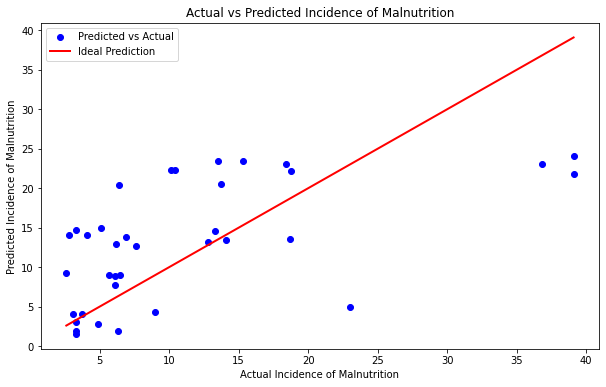

In [8]:
# Make predictions
predictions = lr_model.transform(test_data)

# Select actual and predicted values
predictions_df = predictions.select("prediction", "Incidence of malnutrition").toPandas()

# Use Matplotlib for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['Incidence of malnutrition'], predictions_df['prediction'], color='blue', label='Predicted vs Actual')
plt.plot([predictions_df['Incidence of malnutrition'].min(), predictions_df['Incidence of malnutrition'].max()],
          [predictions_df['Incidence of malnutrition'].min(), predictions_df['Incidence of malnutrition'].max()],
          color='red', linewidth=2, label='Ideal Prediction')
plt.xlabel('Actual Incidence of Malnutrition')
plt.ylabel('Predicted Incidence of Malnutrition')
plt.title('Actual vs Predicted Incidence of Malnutrition')
plt.legend()
plt.show()


# Model 2: Decision Tree Model

In [10]:
from pyspark.sql import SparkSession

#Initialize SparkSession
spark = SparkSession.builder \
     .appName("DecisionTreeClassifierModel") \
     .getOrCreate()

data_path = "Fin.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)



In [11]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

#Define feature columns
feature_columns = ['Year', 'Income Level', 'GDP(mean)', 'Total_Expenditure_CG']

# Combine feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

#Convert target column to index label
indexer = StringIndexer(inputCol="Incidence of malnutrition", outputCol="label")
df = indexer.fit(df).transform(df)

# Select features and target columns
df = df.select("features", "label")

# Split the dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# View split results
print("Training Data Count: " + str(train_data.count()))
print("Testing Data Count: " + str(test_data.count()))
from pyspark.ml.classification import DecisionTreeClassifier

#Initialize the decision tree classification model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# Train the model on the training set
dt_model = dt.fit(train_data)
# Make predictions
predictions = dt_model.transform(test_data)

# Select actual and predicted values
predictions.select("prediction", "label").show(5)

# Calculate model evaluation indicators
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
     labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % accuracy)

Training Data Count: 214
Testing Data Count: 36
+----------+-----+
|prediction|label|
+----------+-----+
|      93.0|  0.0|
|       0.0| 82.0|
|       0.0|113.0|
|       4.0|101.0|
|       4.0|143.0|
+----------+-----+
only showing top 5 rows

Test Error = 0.944444
Accuracy = 0.0555556


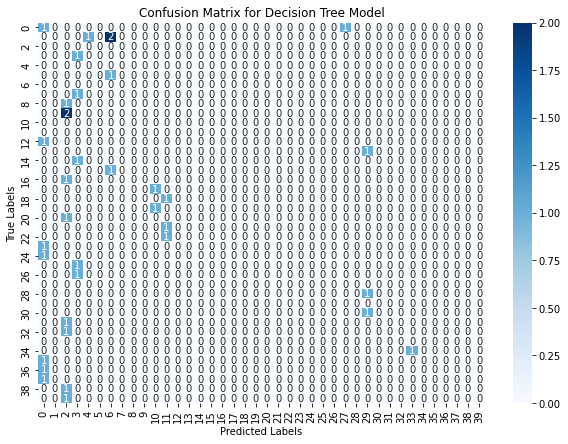

In [14]:
# Make predictions
predictions = dt_model.transform(test_data)

# Select actual and predicted values
predictions_and_labels = predictions.select("prediction", "label").toPandas()

# Use confusion matrix for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(predictions_and_labels['label'], predictions_and_labels['prediction'])

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()


# Model 3: Random Forest Model

In [16]:
from pyspark.sql import SparkSession

#Initialize SparkSession
spark = SparkSession.builder \
     .appName("RandomForestClassifierModel") \
     .getOrCreate()
# Download Data
data_path = "Fin.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

Training Data Count: 214
Testing Data Count: 36


24/05/23 15:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1137.8 KiB
24/05/23 15:56:16 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 15:56:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/23 15:56:20 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


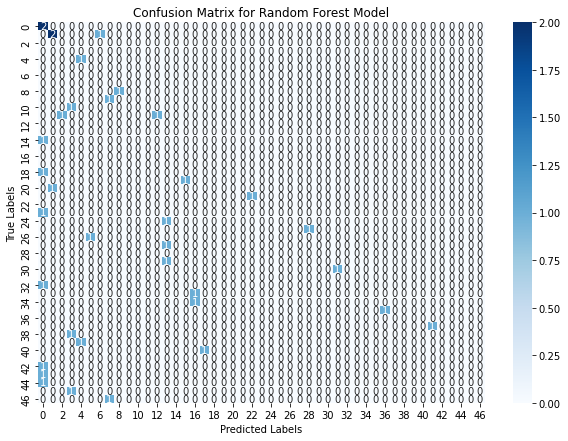

24/05/23 15:56:28 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


Test Error = 0.833333
Accuracy = 0.166667


In [17]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

#Define feature columns
feature_columns = [
     'Year', 'Income Level', 'GDP(mean)', 'Total_Expenditure_CG',
     'Agriculture_CG', 'Children_Under_5_Wasting_Percent'
]

# Combine feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

#Convert target column to index label
indexer = StringIndexer(inputCol="Incidence of malnutrition", outputCol="label")
df = indexer.fit(df).transform(df)

# Select features and target columns
df = df.select("features", "label")

# Split the dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# View split results
print("Training Data Count: " + str(train_data.count()))
print("Testing Data Count: " + str(test_data.count()))

from pyspark.ml.classification import RandomForestClassifier

#Initialize the random forest classification model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100)

# Train the model on the training set
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Select actual and predicted values
predictions_and_labels = predictions.select("prediction", "label").toPandas()

# Use confusion matrix for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(predictions_and_labels['label'], predictions_and_labels['prediction'])

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Calculate model evaluation indicators
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
     labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % accuracy)
